In [153]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# FUNCTIONS

In [154]:
def describe_in_xarray(ds: xr.Dataset):
    print(f"\t\t Mean \t   Std \t     Min\tMax")
    for var_name, variable in ds.data_vars.items():
        mean = variable.mean().values
        std = variable.std().values
        min = variable.min().values
        max = variable.max().values
        print(f"{var_name:<10}     {mean:^7.3f}   {std:^7.3f}   {min:^7.3f}   {max:^7.3f}")

In [155]:
def print_nan_calculatations(dsx: xr.Dataset):
    for var_name, data_array in dsx.data_vars.items():
        total_nan = data_array.isnull().sum().item()
        total_non_nan = data_array.notnull().sum().item()

        total_elements = data_array.size

        nan_percentage = (total_nan / total_elements) * 100
        non_nan_percentage = (total_non_nan / total_elements) * 100

        print(f"{var_name:<10} Total NaNs: {total_nan:^10} Total Non-Nan: {total_non_nan:^10} NaN Percentage: {nan_percentage:^4.2f}%   Non-NaN Percentage: {non_nan_percentage:^4.2f}%")

# STL1, TP, SWVL1, U10, V10 & SSR Exploratory Data Analysis

In [156]:
# Little script to unzip the files and change the name from data.nc
! cd ../data/raw/other_variables_data/; for file in *.zip; do unzip "$file"; mv "data.nc" "${file%.zip}.nc"; done

Archive:  METEO_DATA_01_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_01_2021.zip
  inflating: data.nc                 


Archive:  METEO_DATA_02_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_03_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_04_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_05_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_06_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_07_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_08_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_09_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_10_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_11_2018.zip
  inflating: data.nc                 
Archive:  METEO_DATA_12_2018.zip
  inflating: data.nc                 


In [157]:
path_SL_01_18 = "../data/raw/other_variables_data/METEO_DATA_01_2018.nc"

ds = xr.open_dataset(path_SL_01_18)
for i in range(1, 13):
    path_aux = f"../data/raw/other_variables_data/METEO_DATA_{i:02d}_2018.nc"
    with xr.open_dataset(path_aux) as ds_aux:
            ds = xr.concat([ds, ds_aux], dim="time")

In [158]:
ds

<xarray.Dataset>
Dimensions:    (longitude: 71, latitude: 41, time: 9504)
Coordinates:
  * longitude  (longitude) float32 -8.0 -7.9 -7.8 -7.7 ... -1.3 -1.2 -1.1 -1.0
  * latitude   (latitude) float32 39.0 38.9 38.8 38.7 ... 35.3 35.2 35.1 35.0
  * time       (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    stl1       (time, latitude, longitude) float32 281.3 281.9 ... 279.2 278.9
    tp         (time, latitude, longitude) float32 0.001718 ... 1.766e-06
    swvl1      (time, latitude, longitude) float32 0.2324 0.3148 ... 0.3006
    u10        (time, latitude, longitude) float32 0.3585 0.5566 ... -0.5192
    v10        (time, latitude, longitude) float32 1.521 1.372 ... 1.832 1.876
    ssr        (time, latitude, longitude) float32 4.229e+06 ... 9.704e+06
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-03 12:50:47 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [159]:
print("Dataset Info:")
print(ds.info())


Dataset Info:
xarray.Dataset {
dimensions:
	longitude = 71 ;
	latitude = 41 ;
	time = 9504 ;

variables:
	float32 longitude(longitude) ;
		longitude:units = degrees_east ;
		longitude:long_name = longitude ;
	float32 latitude(latitude) ;
		latitude:units = degrees_north ;
		latitude:long_name = latitude ;
	datetime64[ns] time(time) ;
		time:long_name = time ;
	float32 stl1(time, latitude, longitude) ;
		stl1:units = K ;
		stl1:long_name = Soil temperature level 1 ;
		stl1:standard_name = surface_temperature ;
	float32 tp(time, latitude, longitude) ;
		tp:units = m ;
		tp:long_name = Total precipitation ;
	float32 swvl1(time, latitude, longitude) ;
		swvl1:units = m**3 m**-3 ;
		swvl1:long_name = Volumetric soil water layer 1 ;
	float32 u10(time, latitude, longitude) ;
		u10:units = m s**-1 ;
		u10:long_name = 10 metre U wind component ;
	float32 v10(time, latitude, longitude) ;
		v10:units = m s**-1 ;
		v10:long_name = 10 metre V wind component ;
	float32 ssr(time, latitude, longitude)

In [160]:
# Just to make sure that the date values are indeed correct (from January to December)
print(ds["time"].min().values)
print(ds["time"].max().values)

2018-01-01T00:00:00.000000000
2018-12-31T23:00:00.000000000


In [161]:
# Resampling of the data so that the plots are not hourly
# I've also tried it with a 7 day resampling mean and while the plots are smoother it doesn't add that much info

num_time_steps_before = ds.time.size

ds = ds.sortby("time")  # Necessary to use resample based on time
ds = ds.resample(time='3D').mean()

num_time_steps_after = ds.time.size

print(f"Number of time registers before resampling: {num_time_steps_before}")
print(f"Number of time registers after resampling: {num_time_steps_after}")


Number of time registers before resampling: 9504
Number of time registers after resampling: 122


In [162]:
# Because we don't have an specific .describe() method for xarray.Dataset
describe_in_xarray(ds)

		 Mean 	   Std 	     Min	Max
stl1           290.339    8.029    272.900   311.206
tp              0.001     0.002     0.000     0.022 
swvl1           0.261     0.104     0.015     0.498 
u10             0.627     1.559    -10.060    8.920 
v10             0.001     1.124    -7.012     6.333 
ssr            7420109.500   3047484.750   1314466.125   14069236.000


U10 and V10 can take negative values basically because they represent the speed of the wind from a direction to another. U10 will take postive values from west to east and negative ones from east to west.

In [163]:
print_nan_calculatations(ds)

stl1       Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
tp         Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
swvl1      Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
u10        Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
v10        Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
ssr        Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%


Given that there is a value for each hour, a mean or LCF for inputing NaNs might work, however, there is almost a 40% of missing values,
Do we need a high fidelity dataset? Can it make our model worse?
Straight NaN drop??

In [164]:
for var_name, _ in ds.data_vars.items():
    ds[var_name] = ds[var_name].interpolate_na(dim="time", method="linear")

print_nan_calculatations(ds)

stl1       Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
tp         Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
swvl1      Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
u10        Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
v10        Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%
ssr        Total NaNs:   136884   Total Non-Nan:   218258   NaN Percentage: 38.54%   Non-NaN Percentage: 61.46%


The percentages are not changing, might be that there are not enought values to interpolate.
The .interpolate_na() method needs the value before and after the NaN value to interpolate, if not, it won't apply it

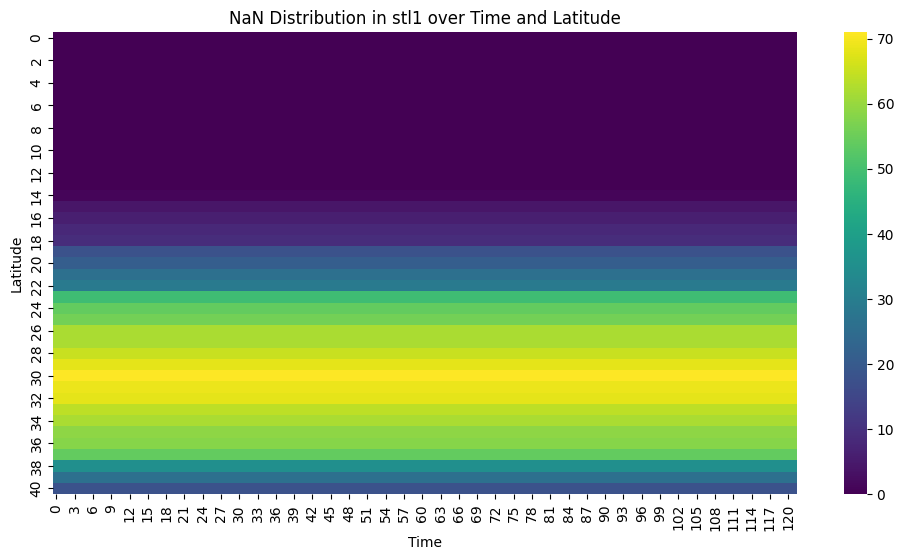

In [165]:
# NaN distribution
variable = ds['swvl1']

nan_matrix = np.isnan(variable).sum(dim='longitude').T 

plt.figure(figsize=(12, 6))
sns.heatmap(nan_matrix, cmap='viridis', cbar=True)
plt.title('NaN Distribution in stl1 over Time and Latitude')
plt.xlabel('Time')
plt.ylabel('Latitude')
plt.show()

The problem might just be that the NaNs are surrounded by at leat another NaN in most cases, which makes it impossible to use the mean of the previous and next values.
Maybe input the mean of each variable? Tendency to delta distribution therefore?

In [166]:
# NaNs inputed for each variable mean
# for var_name, _ in ds.data_vars.items():
#     ds[var_name] = ds[var_name].fillna(ds[var_name].mean())

In [167]:
# for var_name, _ in ds.data_vars.items():
#     ds[var_name] = ds[var_name].dropna(dim="time")

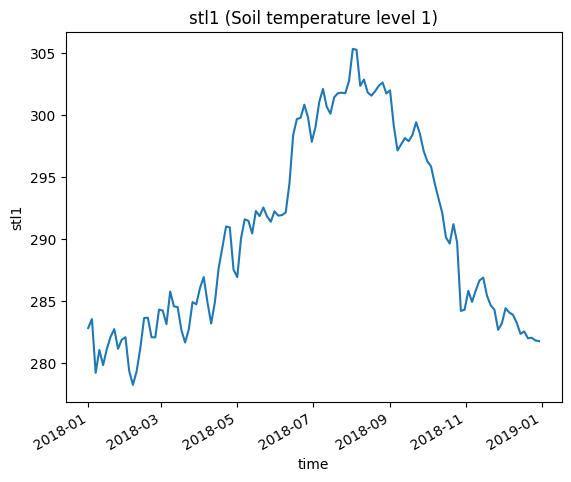

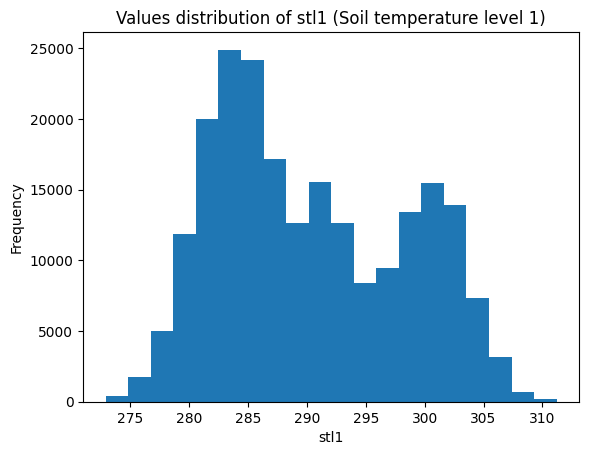

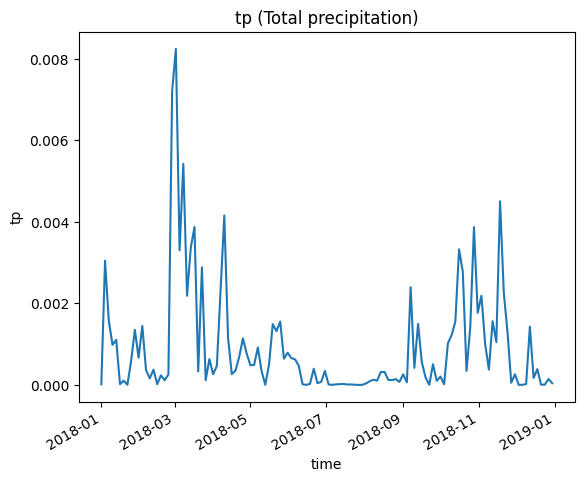

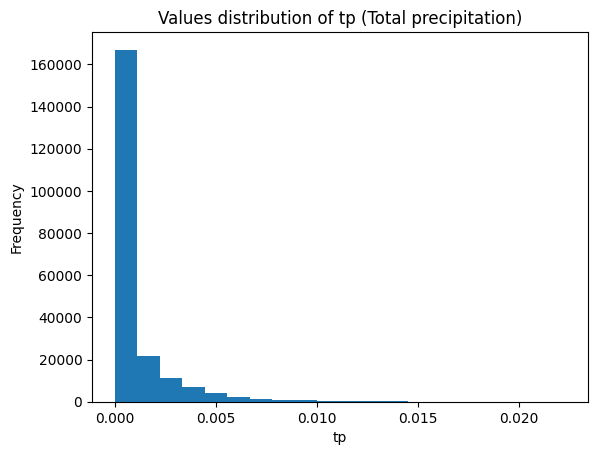

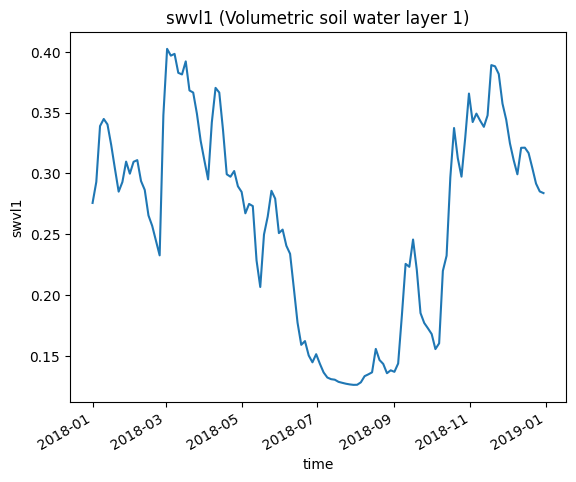

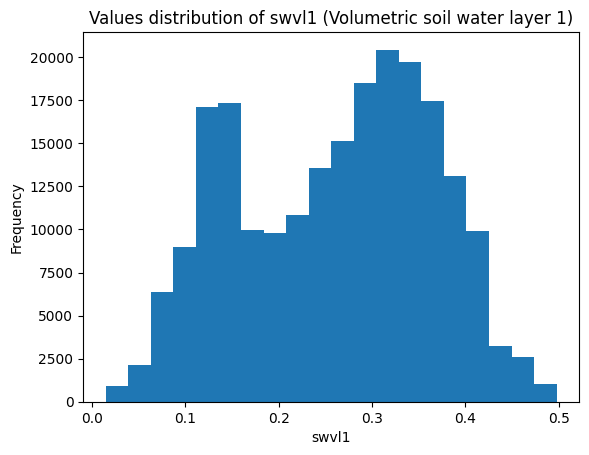

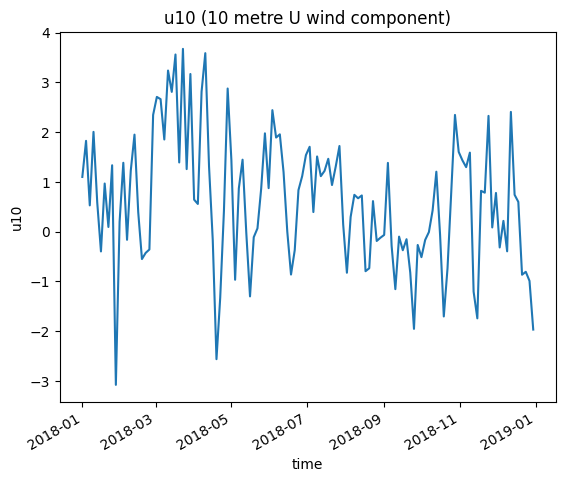

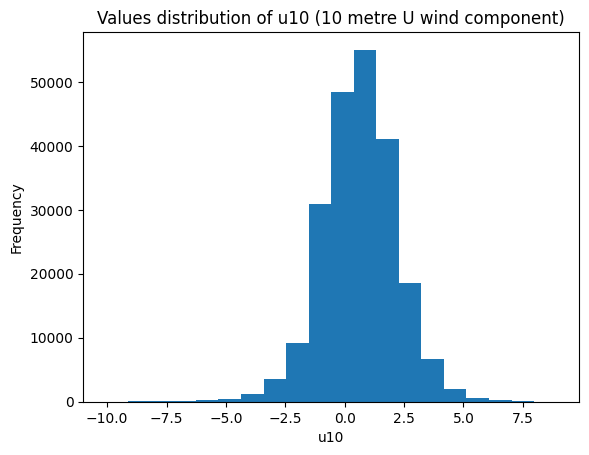

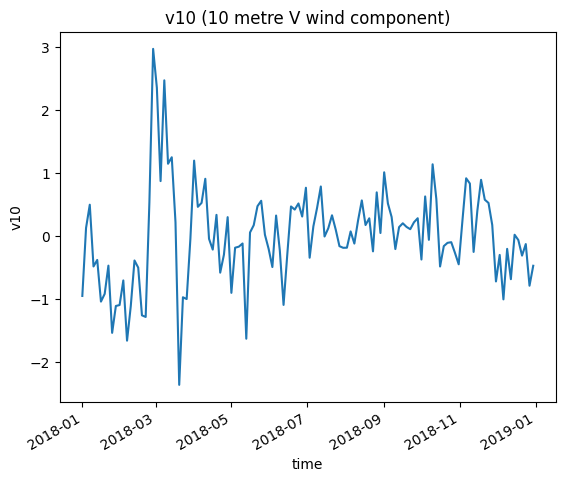

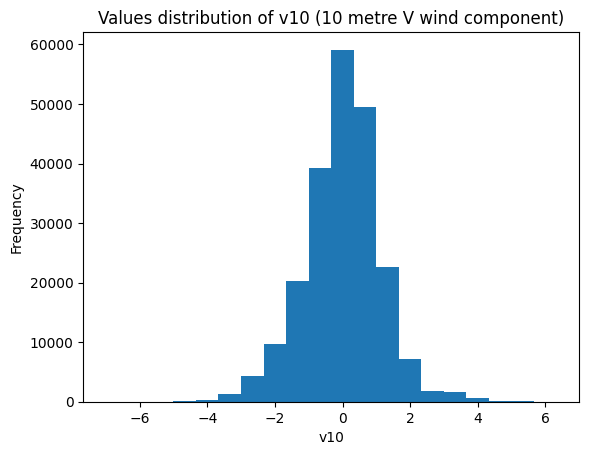

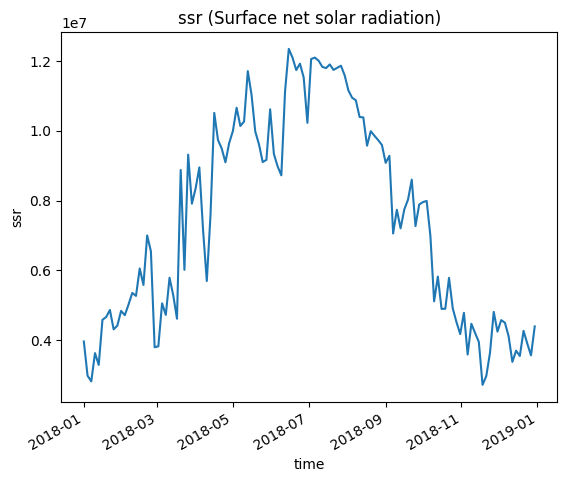

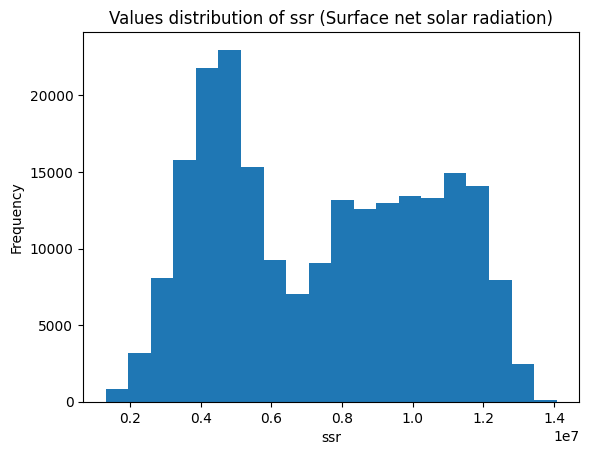

In [168]:
for var in ds.data_vars:
    # Time series plot
    ds[var].mean(dim=['latitude', 'longitude']).plot()
    plt.title(f"{var} ({ds[var].long_name})")
    plt.show()

    # Value distribution plot
    ds[var].plot.hist(bins=20)  # Value of bins is arbitrary
    plt.title(f"Values distribution of {var} ({ds[var].long_name})")
    plt.xlabel(var)
    plt.ylabel('Frequency')
    plt.show()

# FAPAR NDVI Exploratory Data Analysis

In [169]:
path_fapar = "../data/raw/003-00073-00-00_BIOPAR_FAPAR_V2_GLOBAL_2006_05_08_2021_09_23.txt"
path_ndvi = "../data/raw/003-00073-00-00_BIOPAR_NDVI_V2_GLOBAL_2006_05_08_2021_09_23.txt"

In [170]:
# Even if the files are .txt, the csv method works just fine
# In this case, the data is separated by tabs, ther is an index column and the dates have to be parsed
ds_fapar = pd.read_csv(path_fapar, sep="\t", index_col=0, parse_dates=["date"])
ds_ndvi = pd.read_csv(path_ndvi, sep="\t", index_col=0, parse_dates=["date"])

In [171]:
ds_fapar = ds_fapar.rename(columns={"value": "fapar"})
ds_ndvi = ds_ndvi.rename(columns={"value": "ndvi"})
ds_fapar.describe()

,date,fapar
count,510,510.000000
mean,2013-06-05 00:16:56.470588160,0.252902
min,2006-05-10 00:00:00,0.104000
25%,2009-11-22 12:00:00,0.188000
50%,2013-06-05 00:00:00,0.252000
75%,2016-12-17 12:00:00,0.315000
max,2020-06-30 00:00:00,0.460000
std,NaN,0.080305


In [172]:
ds_ndvi.describe()

,date,ndvi
count,528,521.000000
mean,2013-09-05 08:13:38.181818368,0.345190
min,2006-05-11 00:00:00,0.220000
25%,2010-01-08 12:00:00,0.300000
50%,2013-09-06 00:00:00,0.340000
75%,2017-05-03 12:00:00,0.380000
max,2021-01-01 00:00:00,0.548000
std,NaN,0.057982


In [173]:
ds_fapar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 510 entries, 0 to 509
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    510 non-null    datetime64[ns]
 1   fapar   510 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.0 KB


In [174]:
ds_ndvi.info()

<class 'pandas.core.frame.DataFrame'>
Index: 528 entries, 0 to 527
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    528 non-null    datetime64[ns]
 1   ndvi    521 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 12.4 KB


NaNs?
In this case, the time between each value is 10 days apart, doing a mean or LCF wouldn't be a good solution due to the variability of the data.
The best solution is probably to drop them

FAPAR

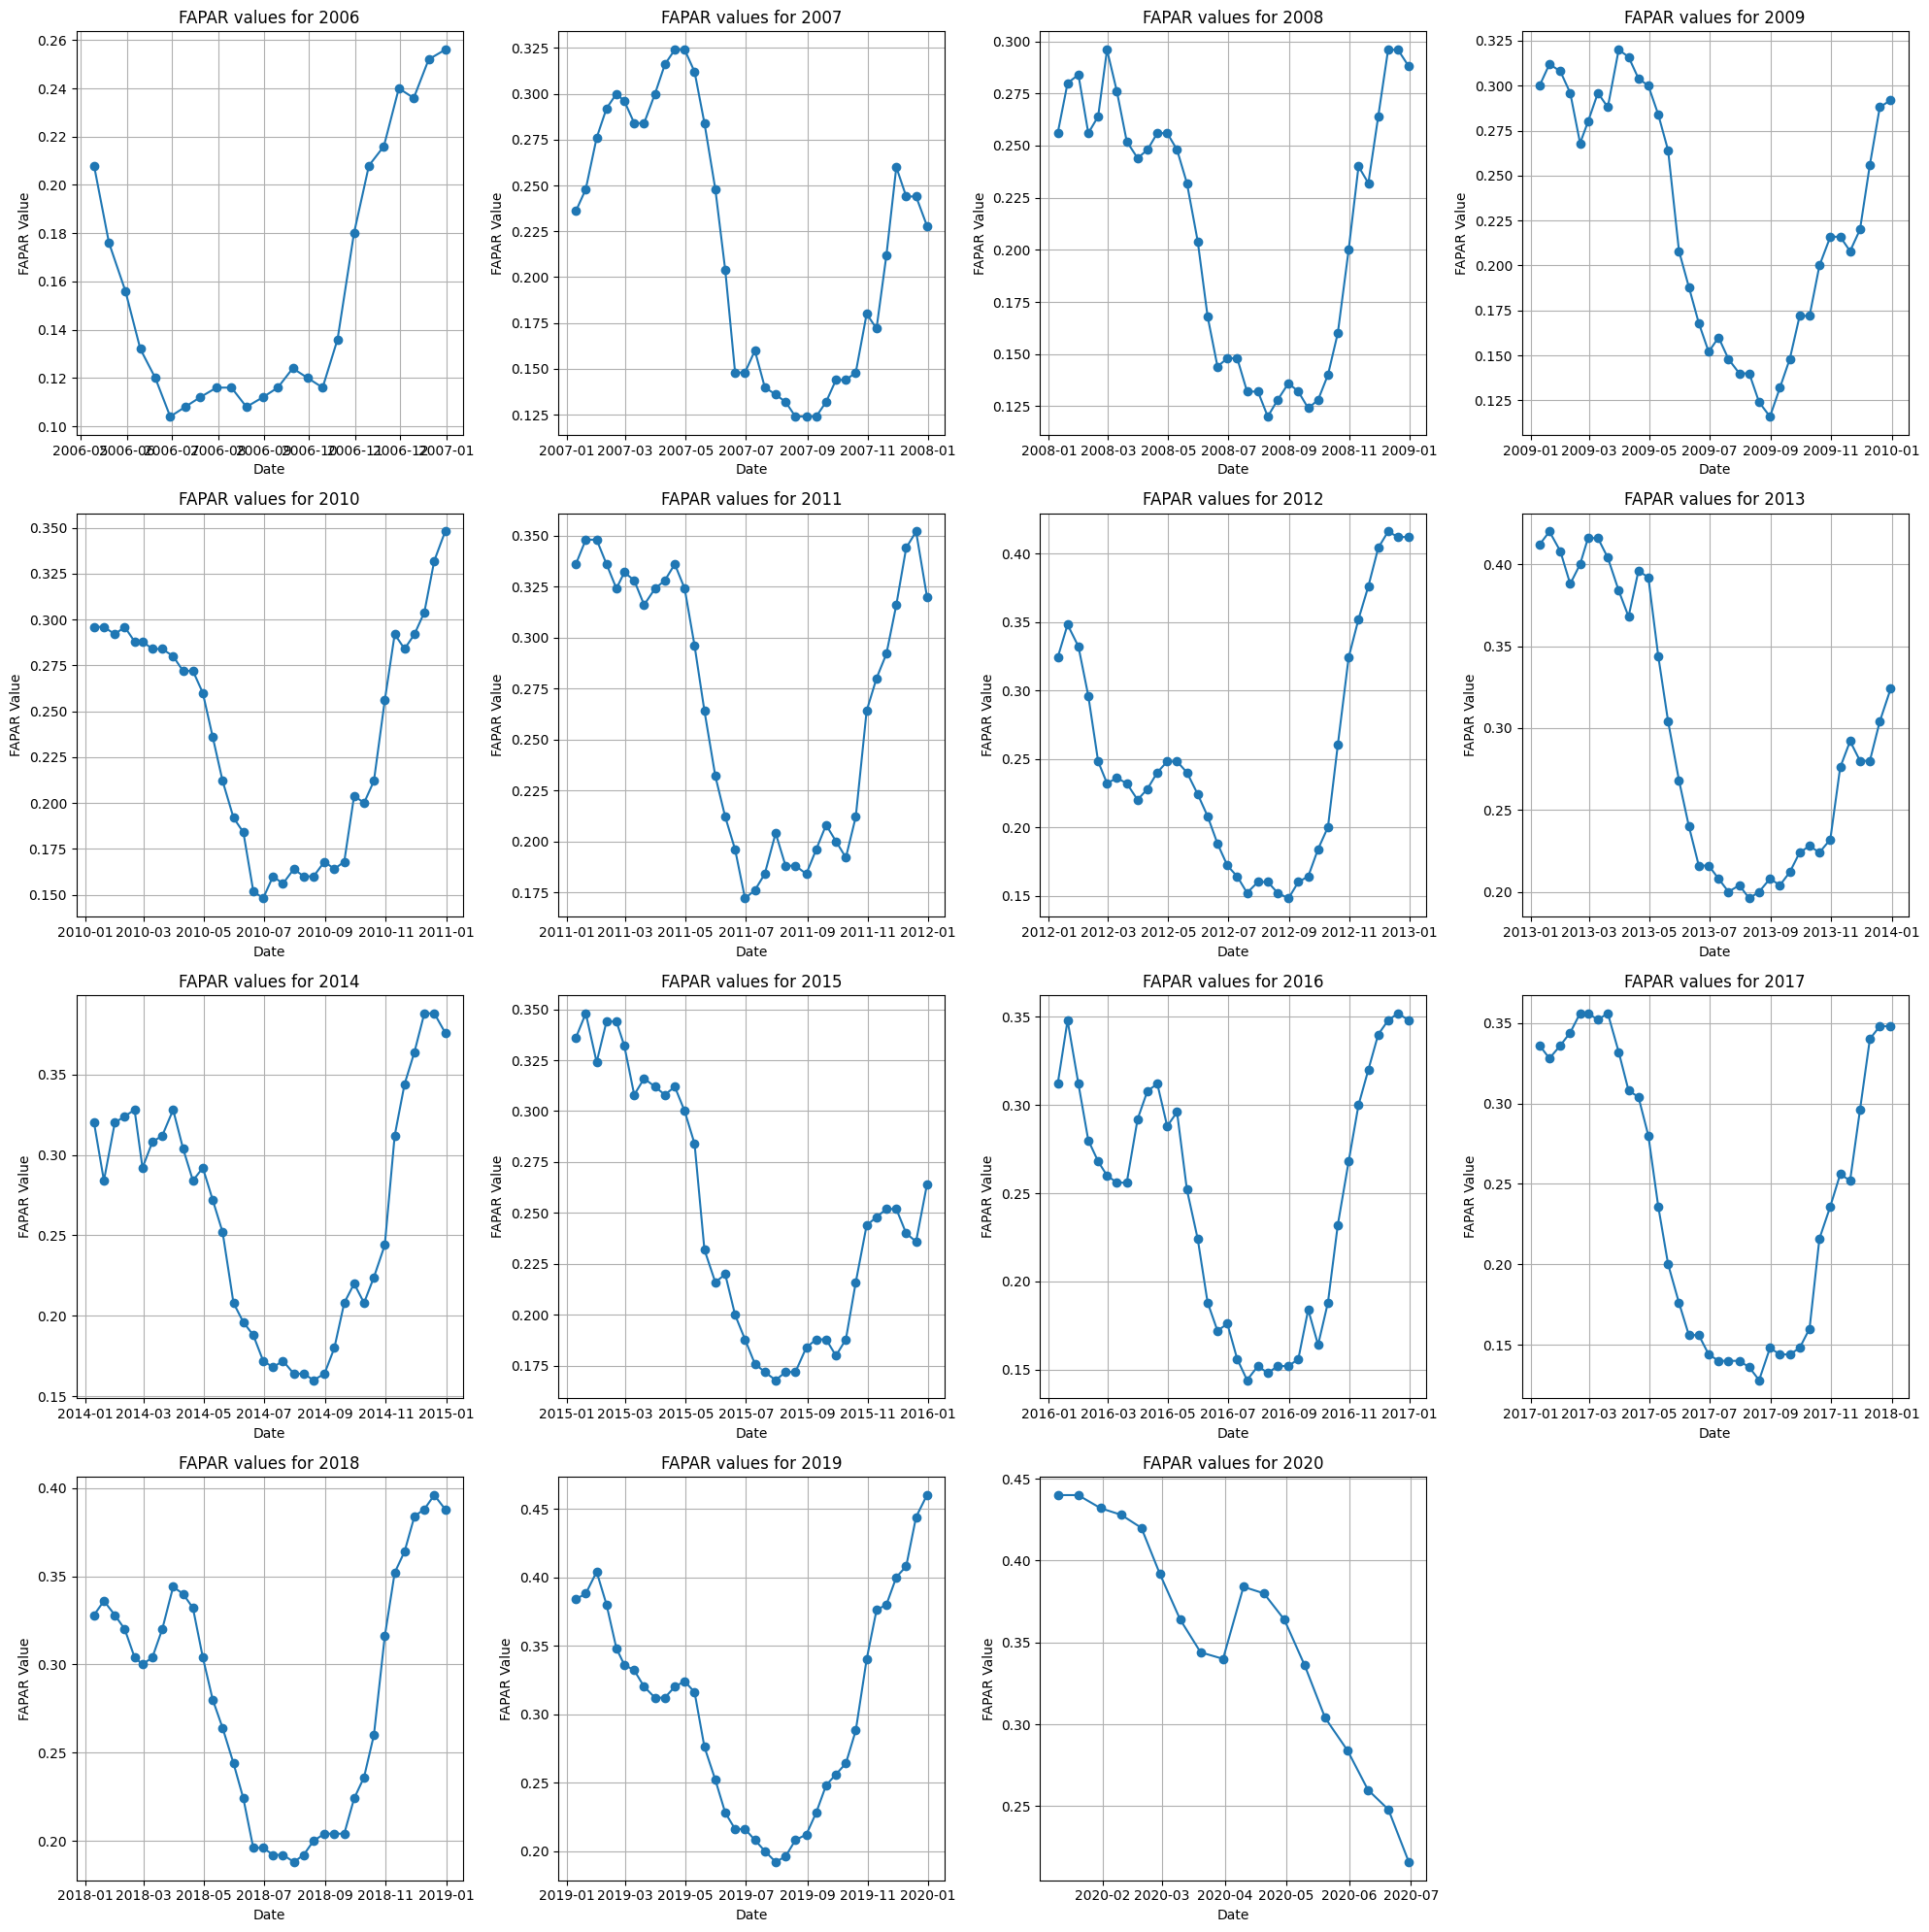

In [175]:
# for year in ds_fapar["date"].dt.year.unique():
#     plt.figure(figsize=(3, 2))
#     plt.plot(ds_fapar[ds_fapar["date"].dt.year == year]["fapar"], marker='o', linestyle='-')
#     plt.title(f"FAPAR values for {year}")
#     plt.xlabel("Date")
#     plt.ylabel("FAPAR Value")
#     plt.grid(True)
#     plt.show()


# Plot for each FAPAR values year

years = ds_fapar["date"].dt.year.unique()

# We'll show 4 year plots per row
num_cols = 4
num_rows = int(np.ceil(len(years) / num_cols))

plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size as needed

for i, year in enumerate(years):
    plt.subplot(num_rows, num_cols, i + 1)
    yearly_data = ds_fapar[ds_fapar["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['fapar'], marker='o', linestyle='-')
    plt.title(f"FAPAR values for {year}")
    plt.xlabel("Date")
    plt.ylabel("FAPAR Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

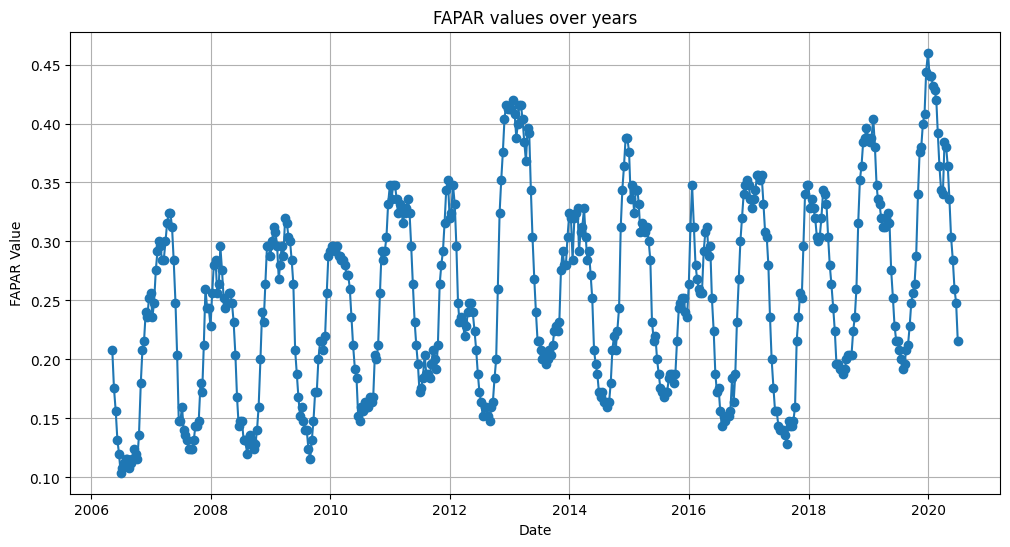

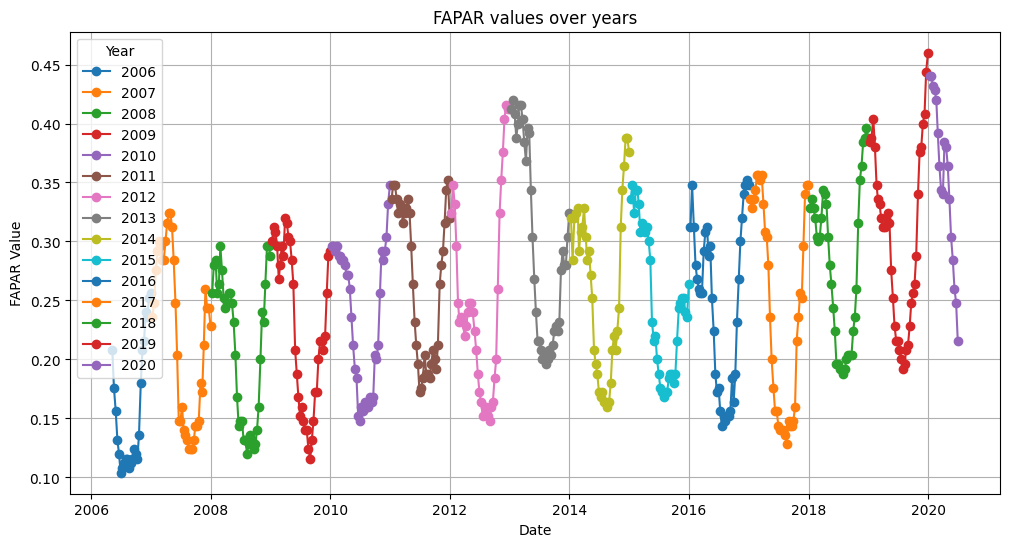

In [176]:
# FAPAR values over the years with and without year division

# Without year division
plt.figure(figsize=(12, 6))
plt.plot(ds_fapar['date'], ds_fapar['fapar'], marker='o', linestyle='-')
plt.title("FAPAR values over years")
plt.xlabel("Date")
plt.ylabel("FAPAR Value")
plt.grid(True)
plt.show()


# With year division
plt.figure(figsize=(12, 6))

for year in ds_fapar["date"].dt.year.unique().tolist():
    # Filter the data for each year and plot it on the same figure
    yearly_data = ds_fapar[ds_fapar["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['fapar'], marker='o', linestyle='-', label=str(year))

plt.title("FAPAR values over years")
plt.xlabel("Date")
plt.ylabel("FAPAR Value")
plt.legend(title='Year')  # Without this, it's not possible to know which line corresponds to which year
plt.grid(True)
plt.show()


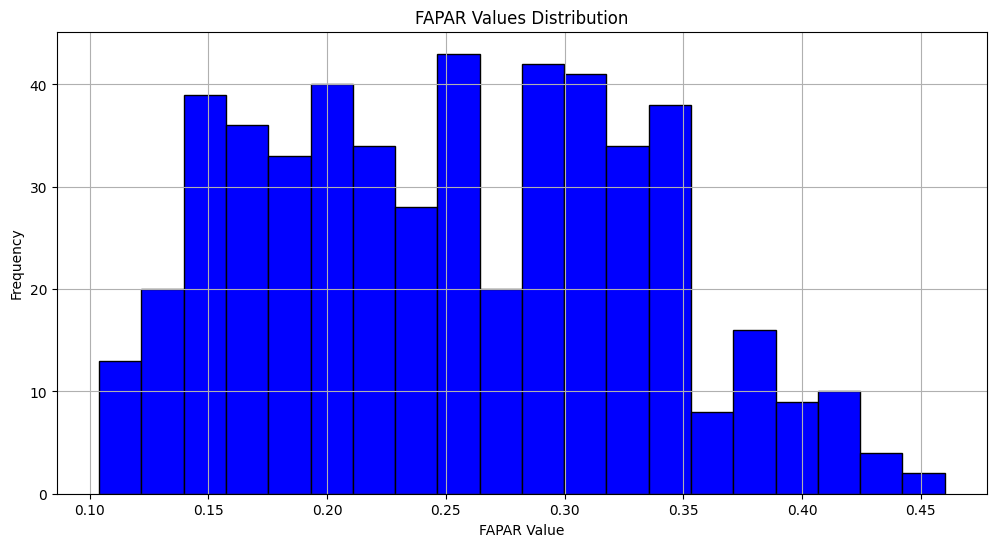

In [177]:
# Histogram of distribution
plt.figure(figsize=(12, 6))
plt.hist(ds_fapar['fapar'], bins=20, color='blue', edgecolor='black')
plt.title('FAPAR Values Distribution')
plt.xlabel('FAPAR Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

NDVI

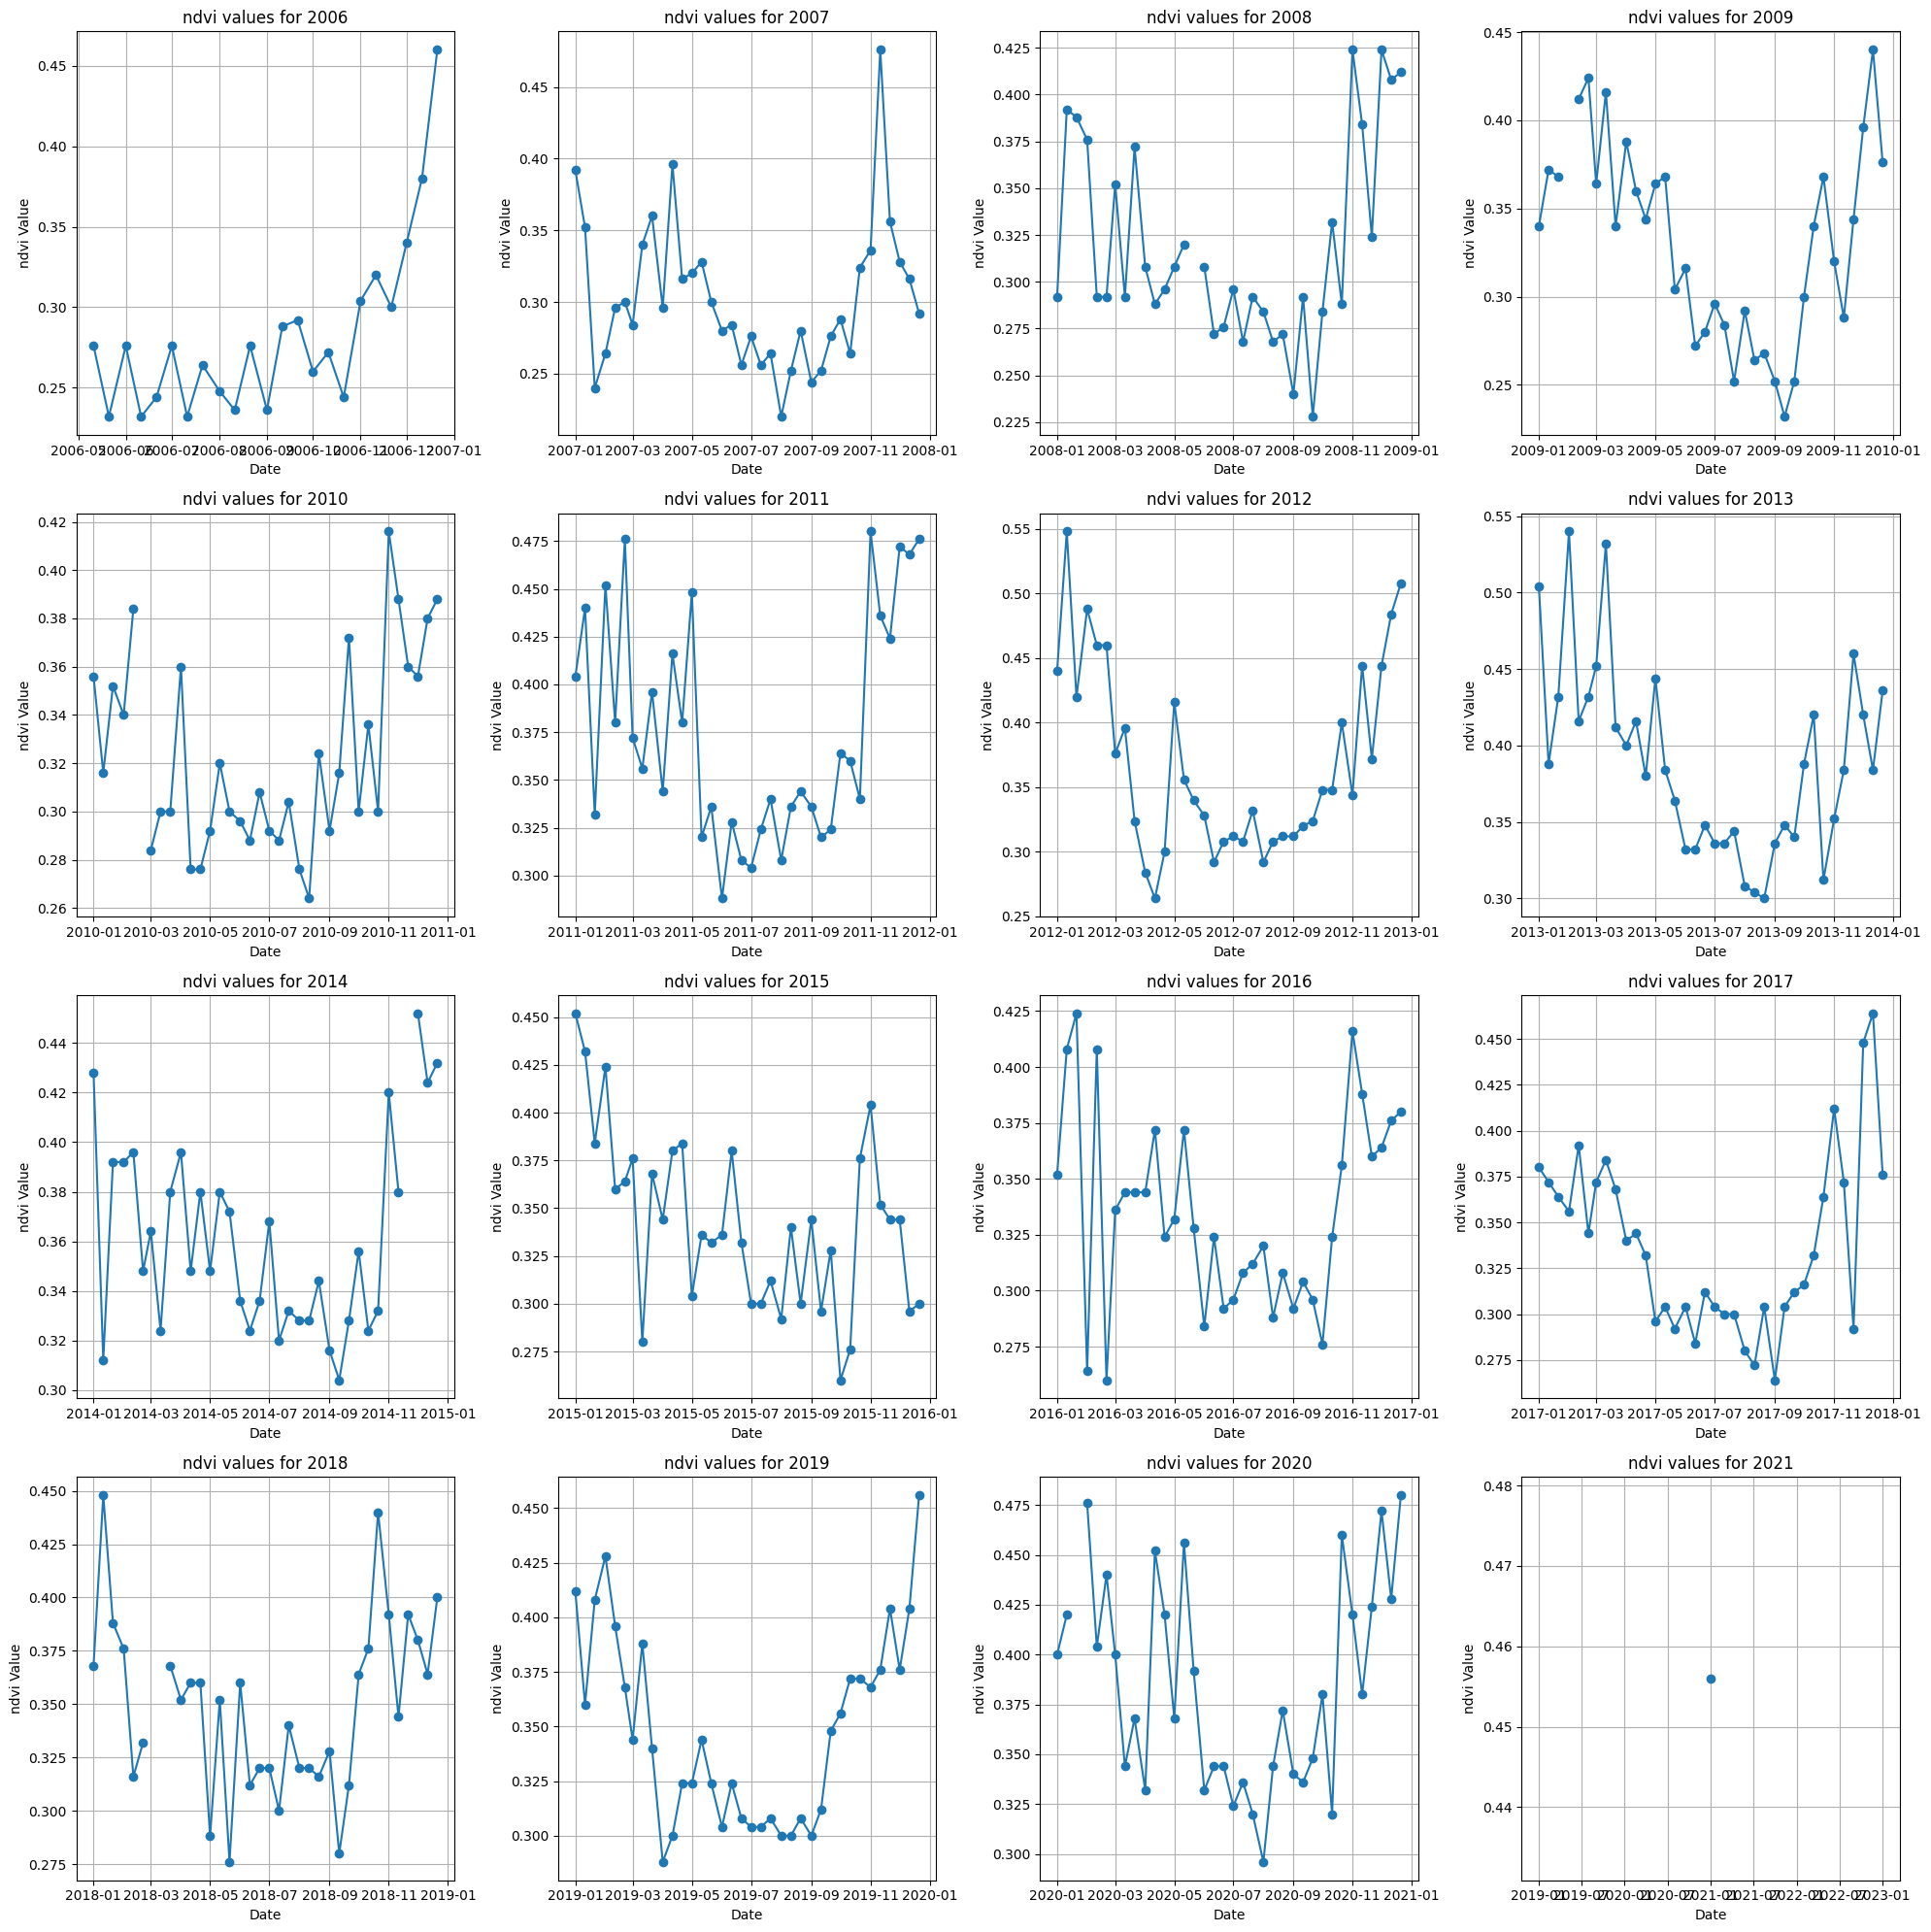

In [178]:
years = ds_ndvi["date"].dt.year.unique()
num_cols = 4
num_rows = int(np.ceil(len(years) / num_cols))

plt.figure(figsize=(20, num_rows * 5))  # Adjust the figure size as needed

for i, year in enumerate(years):
    plt.subplot(num_rows, num_cols, i + 1)
    yearly_data = ds_ndvi[ds_ndvi["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['ndvi'], marker='o', linestyle='-')
    plt.title(f"ndvi values for {year}")
    plt.xlabel("Date")
    plt.ylabel("ndvi Value")
    plt.grid(True)

plt.tight_layout()
plt.show()

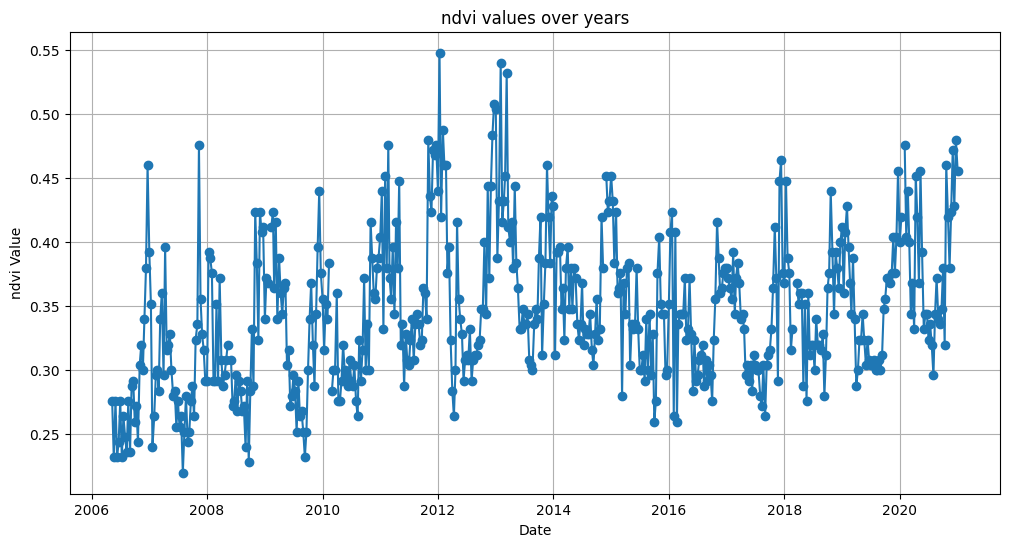

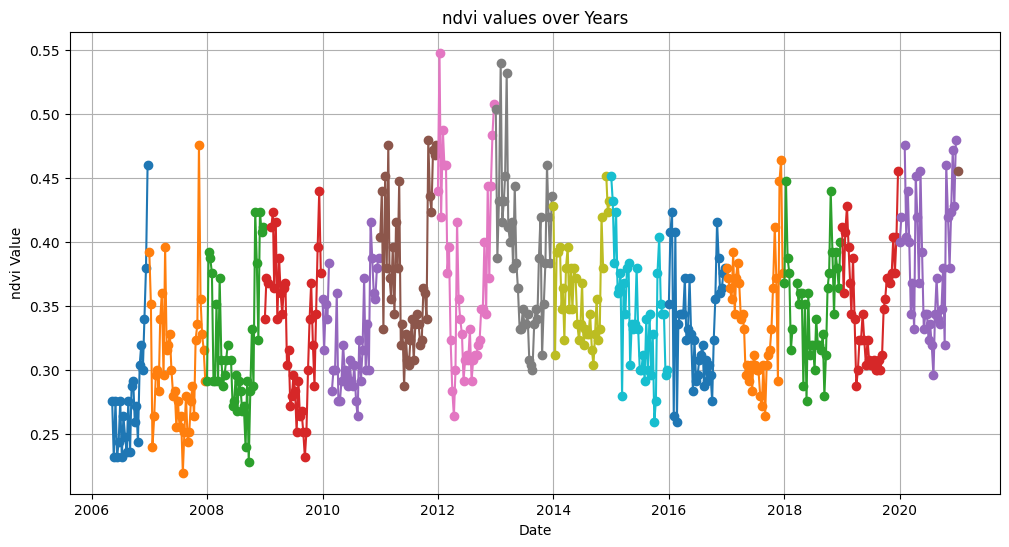

In [179]:
# ndvi values over the years with and without year division

# Without year division
plt.figure(figsize=(12, 6))
plt.plot(ds_ndvi['date'], ds_ndvi['ndvi'], marker='o', linestyle='-')
plt.title("ndvi values over years")
plt.xlabel("Date")
plt.ylabel("ndvi Value")
plt.grid(True)
plt.show()


# With year division
plt.figure(figsize=(12, 6))

for year in ds_ndvi["date"].dt.year.unique().tolist():
    # Filter the data for each year and plot it on the same figure
    yearly_data = ds_ndvi[ds_ndvi["date"].dt.year == year]
    plt.plot(yearly_data['date'], yearly_data['ndvi'], marker='o', linestyle='-', label=str(year))

plt.title("ndvi values over Years")
plt.xlabel("Date")
plt.ylabel("ndvi Value")
plt.grid(True)
plt.show()

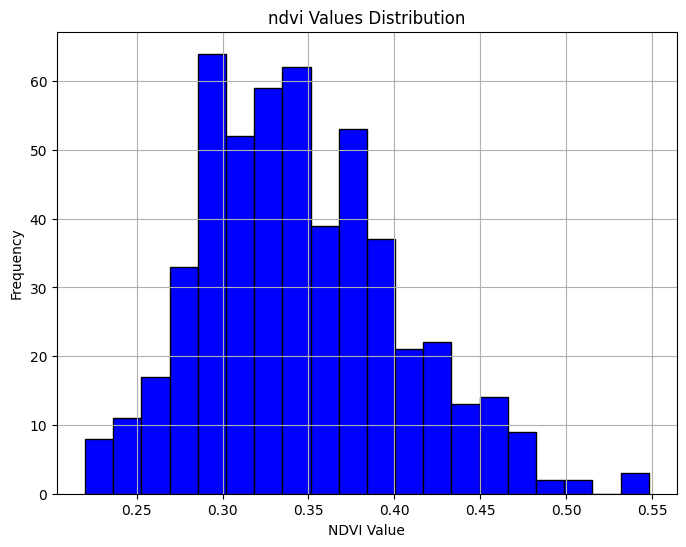

In [180]:
# Histogram of distribution
plt.figure(figsize=(8, 6))
plt.hist(ds_ndvi['ndvi'], bins=20, color='blue', edgecolor='black')
plt.title('ndvi Values Distribution')
plt.xlabel('NDVI Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Conclusions

- STL1 measures the soil temperature level at an specific depth.

- SWVL1 represents the volumetric soil water layer, i.e. the amount of water in the soil. Each crop might need a different value for optimal growth

- SSR, surface net solar radiation is the difference between the incoming solar radiation and the reflected and emitter back to the atmosphere. Key to understand evapotransporation.

- STL1, SWVL1 and SSR show a clear seasonal cycle based on the Earth's rotation. The higher values of STL1 and SSR appear on the summer months, where the temperatures are higher, while the SWVL1 has it's lowest values during those months indicating that the soil has less moisture as a result of the evapotransporation of water from the soil due to higher solar radiation and lower precipitation rates.

- TP is the total precipitation.

- In Andalucía most rainfalls occur during autumn and winter (September to February) but there also are some notable peaks during april visible in the TP time series plot.

- U10 and V10 are the wind components (U --> from west to east ; V --> from south to north) at 10 metres from the ground. Affects agriculture pollination and like most of the other variables, could lead to crop damages in case of extreme values.

- Compared to the previous variables, TP, U10 and V10 show much more variability and clearly can't be explained by a phenomenom as simple and as consistent as the cycle of seasons.

- FAPAR measures the fraction of the solar radiation that is absorbed by the vegetation canopy (only the radiation within the limits of the photosynthesis wavelengths). Usually, higher FAPAR values indicate that the vegetation is healthy.

- FAPAR has a cyclic tendency for each year, making a sin function altogether.

- Over the years, we can clearly see the values have been growing consistently, probably due to climate change (CO2 fertilization effect).

- It will be a good idea to look at how FAPAR fluctuates when the olives are ready for haverst. Peak FAPAR values could provide some insight on the current state of the olive

- NDVI measures the normalized difference vegetation index. The difference refers the variation between near-infrared and red light given that the one is reflected and the later absorbed. It's a way to check the "sanity and robust" of the vegetation, being higher values better.

- NDVI is much more irregular than FAPAR thanks to how the data is collected and how it, therefore, reacts to instant environmental changes. However, it's still possible to see that on the mid months of the year, the values seem to be lower than the beggining / end parts. This could perfectly be related with the seasonal growth cycles of the vegetation.

- A lof of noise and outliers.